 #### Adaptado para fins de aprendizagem
 Endereço do notebook original: https://ethen8181.github.io/machine-learning/time_series/3_supervised_time_series.html

In [1]:
%matplotlib inline
%load_ext watermark
%watermark -d -t -v -p numpy,pandas,sklearn,matplotlib

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.22.2

numpy     : 1.26.4
pandas    : 2.2.1
sklearn   : 1.4.2
matplotlib: 3.8.3



In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Demonstração das _**Lag Features**_ com séries simuladas

In [3]:
df1 = pd.DataFrame({
    'time': np.arange(5) + 1,
    'measure': np.array([100, 110, 108, 115, 120], dtype='int64')
})
df1 = df1.set_index('time')
df1

,measure
time,
1,100
2,110
3,108
4,115
5,120


Considerando a observação anterior para prever a próxima

In [4]:
lag_df = pd.DataFrame({
    "X": df1["measure"],
    "Y": df1["measure"].shift(-1),
})
lag_df = lag_df.dropna()
lag_df = lag_df.set_index("X")
lag_df

,Y
X,
100,110.0
110,108.0
108,115.0
115,120.0


Considerando dois tipos de observações correlatas para prever as próximas

In [5]:
df2 = pd.DataFrame({
    'time': np.arange(5) + 1,
    'measure1': np.array([0.2, 0.5, 0.7, 0.4, 1], dtype='float32'),
    'measure2': np.array([88, 89, 87, 88, 90], dtype='int32')
})

lag_df = pd.DataFrame({
    'X1': df2['measure1'],
    'X2': df2['measure2'],
    'Y1': df2['measure1'].shift(-1),
    'Y2': df2['measure2'].shift(-1),
})
lag_df = lag_df.dropna()
lag_df = lag_df.set_index(['X1', 'X2'])
lag_df

,,Y1,Y2
X1,X2,,
0.2,88,0.5,89.0
0.5,89,0.7,87.0
0.7,87,0.4,88.0
0.4,88,1.0,90.0


Demonstração de uma _**Window Feature**_

In [6]:
window = pd.Series([100, 110, 108, 115, 120])
display(window)
display(window.rolling(window=3).mean())

0    100
1    110
2    108
3    115
4    120
dtype: int64

0           NaN
1           NaN
2    106.000000
3    111.000000
4    114.333333
dtype: float64

In [7]:
df = pd.DataFrame({'t': [x for x in range(10)]})

df['t+1'] = df['t'].shift(-1)
df

,t,t+1
0,0,1.0
1,1,2.0
2,2,3.0
3,3,4.0
4,4,5.0
5,5,6.0
6,6,7.0
7,7,8.0
8,8,9.0
9,9,NaN


Importa-se a série Ads, cujas observações são feitas por hora

In [8]:
input_path = os.path.join('..', 'data', 'ads.csv')

ads = pd.read_csv(input_path, index_col='Time', parse_dates=['Time'])
print('dimension: ', ads.shape)
ads.head()

dimension:  (216, 1)


,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


Plotagem da série

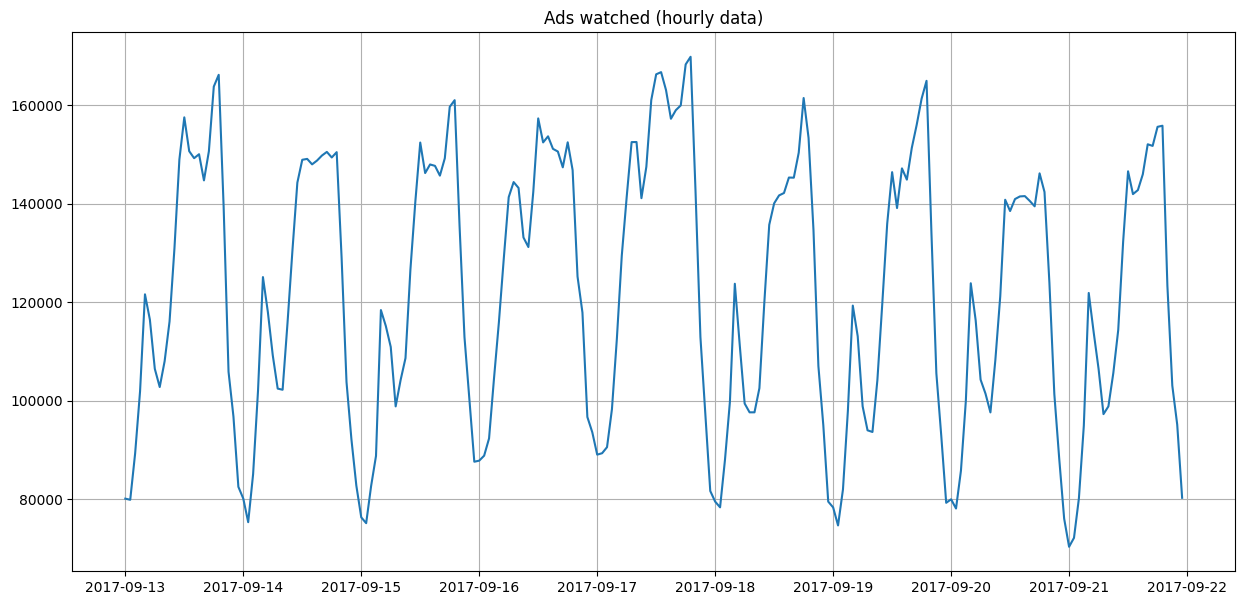

In [9]:
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
plt.figure(figsize=(15, 7))
plt.title('Ads watched (hourly data)')
plt.grid(True)

plt.plot(ads)
plt.show()

Separação das _features_:<br>
* Usam-se a hora, o dia da semana e um identificador de "fim de semana"
* lag_n é uma _lag feature_ que considera a n-ésima observação passada — que é, dado o intervalo de 1 hora, a observação de "n horas atrás".
* A janela (_window_) é de 19, entre 6 e 24 horas atrás.
* Nenhuma linha com valores _**NaN**_ permanece, ou seja, a primeira linha será a observação que foi feita 24 horas depois por possuir dados para preencher todas as features

**data** é um dataframe criado a partir de **ads**, tendo cada _feature_ como coluna e os valores das observações em **y**

In [10]:
data = pd.DataFrame({
    'y': ads['Ads'].copy()
})

# lag_arr = np.char.add('lag_', (np.arange(6, 25)).astype(str))
for i in range(6, 25):
    data[f'lag_{i}'] = data['y'].shift(i) # they turn to float due to NA values

data['hour'] = data.index.hour
data['weekday'] = data.index.weekday
data['is_weekend'] = data['weekday'].isin([5, 6]).astype(np.int32)

data = data.dropna()
display(data.head(5))
display(data.dtypes)


,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-14 00:00:00,80125,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,...,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0,80115.0,0,3,0
2017-09-14 01:00:00,75335,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,...,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0,1,3,0
2017-09-14 02:00:00,85105,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,...,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,2,3,0
2017-09-14 03:00:00,102080,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,...,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,3,3,0
2017-09-14 04:00:00,125135,96780.0,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,...,131030.0,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,4,3,0


y               int64
lag_6         float64
lag_7         float64
lag_8         float64
lag_9         float64
lag_10        float64
lag_11        float64
lag_12        float64
lag_13        float64
lag_14        float64
lag_15        float64
lag_16        float64
lag_17        float64
lag_18        float64
lag_19        float64
lag_20        float64
lag_21        float64
lag_22        float64
lag_23        float64
lag_24        float64
hour            int32
weekday         int32
is_weekend      int32
dtype: object

Por utilizar o método **shift()**, que permite valores **NaN**, as observações em **int64** são convertidas para **float64** quando tornam-se _features_. Com isso, podemos identificar todas as colunas de _lag features_.

Adiciona-se uma _window feature_ que representa a **média** das _lag features_ da linha.

Para fins de treinamento, **data** é separada em **X**, isto é, a coleção de todas as _features_,  e **y**, o valor da observação original para cada horário. Ou seja, o conjunto das observações entre 6 e 24 horas passadas somado à hora, ao dia de semana, ao indicador de final de semana e à media das _lag features_ (**X**) determina o valor da observação (**y**).

In [11]:
lag_columns = data.select_dtypes(include=['float64']).columns
data['rolling_mean'] = data[lag_columns].mean(axis=1)

y = data['y'].values
data = data.drop('y', axis=1)

X = data.values
feature_names = data.columns
print('dimension: ', X.shape)
data.head(5)

dimension:  (192, 23)


,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend,rolling_mean
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-14 00:00:00,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,116125.0,...,116475.0,121630.0,101930.0,89325.0,79885.0,80115.0,0,3,0,124731.052632
2017-09-14 01:00:00,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,...,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0,1,3,0,129263.684211
2017-09-14 02:00:00,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,...,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,2,3,0,132402.368421
2017-09-14 03:00:00,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,...,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,3,3,0,133274.473684
2017-09-14 04:00:00,96780.0,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,...,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,4,3,0,133003.421053


Demonstração da mesma _window feature_ porém produzida com métodos nativos do **pandas** e do **numpy**.

In [12]:
ads['Ads'].shift(6).rolling(window=19).mean().dropna()

Time
2017-09-14 00:00:00    124731.052632
2017-09-14 01:00:00    129263.684211
2017-09-14 02:00:00    132402.368421
2017-09-14 03:00:00    133274.473684
2017-09-14 04:00:00    133003.421053
                           ...      
2017-09-21 19:00:00    106792.368421
2017-09-21 20:00:00    106812.894737
2017-09-21 21:00:00    107974.736842
2017-09-21 22:00:00    110646.315789
2017-09-21 23:00:00    113994.736842
Name: Ads, Length: 192, dtype: float64

Possibilidade de converter as colunas das _lag features_ para **int64**, mas descartou-se a ideia.

In [13]:
# data[lag_columns] = data[lag_columns].astype('int64')
# X = np.concatenate((X[:, :-1].astype('int64'), X[:, -1:]), axis = 1)

Separação do conjunto de treinamento e teste (70-30%) e treinamento com modelo Floresta Aleatóriaa. Utiliza-se **_MAPE_** como métrica de precisão. É utilizado um intervalo de confiança de 95% ao exibir a relação entre os dados e a previsão.

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

def timeseries_train_test_split(X, y, test_size):
    """Perform train-test split with respect to time series structure."""
    test_index = int(len(X) * (1 - test_size))
    X_train = X[:test_index]
    X_test = X[test_index:]
    y_train = y[:test_index]
    y_test = y[test_index:]
    return X_train, X_test, y_train, y_test


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def plot_model_results(X, y, test_size=0.3, plot_intervals=False, plot_anomalies=False):
    """
    - Plots modelled vs original values.
    - Prediction intervals (95% confidence interval).
    - Anomalies (points that resides outside the confidence interval).
    """

    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size)

    model = RandomForestRegressor(max_depth=6, n_estimators=50)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))

    x = range(prediction.size)
    plt.plot(x, prediction, label='prediction', linewidth=2.0)
    plt.plot(x, y_test, label='actual', linewidth=2.0)
    if plot_intervals:
        timeseries_cv = TimeSeriesSplit(n_splits=5)
        cv = cross_val_score(model, X_train, y_train, 
                             cv=timeseries_cv, scoring='neg_mean_absolute_error')
        mae = -1 * cv.mean()
        deviation = cv.std()

        scale = 1.96
        margin_error = mae + scale * deviation
        lower = prediction - margin_error
        upper = prediction + margin_error

        fill_alpha = 0.2
        fill_color = '#66C2D7'
        plt.fill_between(x, lower, upper, color=fill_color, alpha=fill_alpha, label='95% CI')      

        if plot_anomalies:
            anomalies = np.array([np.nan] * len(y_test))
            anomalies[y_test < lower] = y_test[y_test < lower]
            anomalies[y_test > upper] = y_test[y_test > upper]
            plt.plot(anomalies, 'o', markersize=10, label='Anomalies')

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title('Mean absolute percentage error {0:.2f}%'.format(error))
    plt.legend(loc='best')
    plt.tight_layout()
    plt.grid(True)
    
    return model

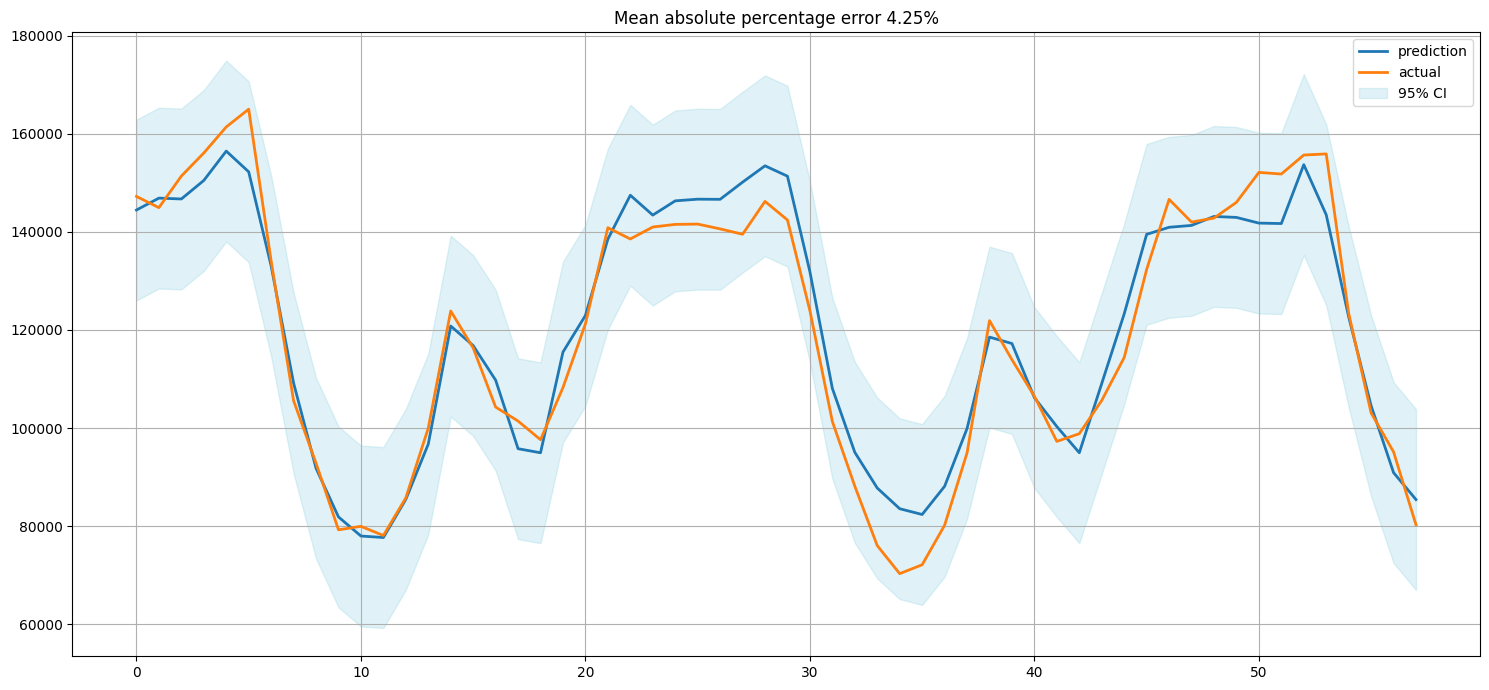

In [15]:
model = plot_model_results(X, y, plot_intervals=True)

Plotagem das _features_ com suas respectivas relevâncias para a previsão.

* Há um valor mínimo (_**threshold**_) para que as _features_ sejam exibidas
* É possível chamar a função com um _array_ **filtered_names**, composto de colunas que deverão ser excluídas da plotagem.

In [16]:
def vis_importance(estimator, feature_names, threshold=0.05, filtered_names=None):
    """
    Visualize the relative importance of predictors.

    Parameters
    ----------
    estimator : sklearn-like ensemble tree model
        A tree estimator that contains the attribute
        ``feature_importances_``.

    feature_names : str 1d array or list[str]
        Feature names that corresponds to the
        feature importance.

    threshold : float, default 0.05
        Features that have importance scores lower than this
        threshold will not be presented in the plot, this assumes
        the feature importance sum up to 1.

    filtered_names : str 1d array or list[str], default None
        Feature names that we wish to exclude from the visualization
        regardless of whether they were in the top features or not.
    """
    if not hasattr(estimator, 'feature_importances_'):
        msg = '{} does not have the feature_importances_ attribute'
        raise ValueError(msg.format(estimator.__class__.__name__))

    imp = estimator.feature_importances_
    feature_names = np.array(feature_names)

    if filtered_names is not None:
        keep = ~np.in1d(feature_names, filtered_names, assume_unique=True)
        mask = np.logical_and(imp > threshold, keep)
    else:
        mask = imp > threshold

    importances = imp[mask]
    idx = np.argsort(importances)
    scores = importances[idx]
    names = feature_names[mask]
    names = names[idx]

    y_pos = np.arange(1, len(scores) + 1)
    if hasattr(estimator, 'estimators_'):
        tree_importances = np.array([tree.feature_importances_
                                     for tree in estimator.estimators_])
        importances_std = np.std(tree_importances[:, mask], axis=0)
        scores_std = importances_std[idx]
        plt.barh(y_pos, scores, align='center', xerr=scores_std)
    else:
        plt.barh(y_pos, scores, align='center')

    plt.yticks(y_pos, names)
    plt.xlabel('Importance')
    plt.title('Feature Importance Plot')

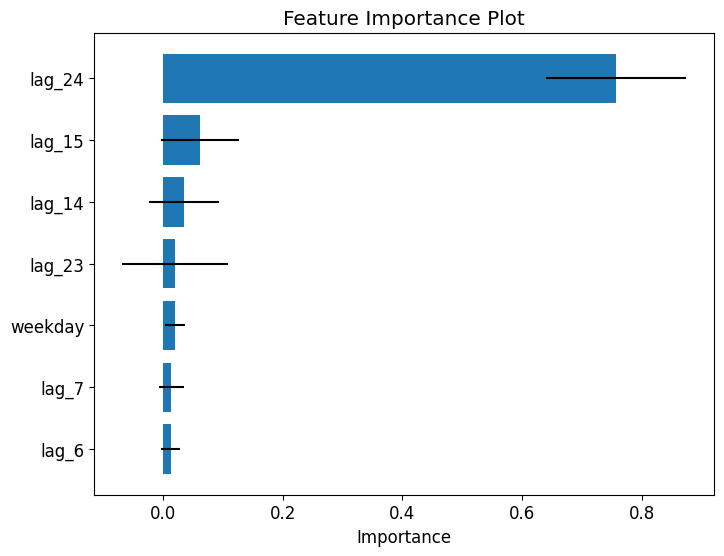

In [17]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

vis_importance(model, feature_names, threshold=0.01)